<h1> Dataset acquisition </h1>

In [2]:
import time
import csv
import threading
import ipywidgets as widgets
from witmotion import IMU
import os


class IMURecorder:
    def __init__(self, port="COM9", filename="imu_data.csv"):
        self.port = port
        self.filename = filename
        self.imu = None
        self.thread = None
        self.stop_flag = threading.Event()

    def start_acquisition(self, filename):
        """Starts data acquisition in a separate thread."""
        self.filename = filename
        if self.imu is None:
            self.imu = IMU(self.port)  # Open connection

        self.stop_flag.clear()
        self.thread = threading.Thread(target=self._acquire_data, daemon=True)
        self.thread.start()
        print(f"IMU acquisition started. Saving to {self.filename}...")

    def _acquire_data(self):
        """Internal method to acquire and save IMU data."""
        with open(self.filename, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(["Time (s)", "Accel X", "Accel Y", "Accel Z", "Gyro X", "Gyro Y", "Gyro Z"])  # Header

            start_time = time.time()

            while not self.stop_flag.is_set():
                current_time = time.time() - start_time
                a = self.imu.get_acceleration()
                g = self.imu.get_angular_velocity()

                if a and g:
                    writer.writerow([current_time, a[0], a[1], a[2], g[0], g[1], g[2]])

                time.sleep(0.1)  # Sampling interval

    def stop_acquisition(self):
        """Stops the data acquisition and closes the IMU connection."""
        if self.imu:
            self.stop_flag.set()
            self.thread.join()  # Wait for thread to exit
            self.imu.close()  # Properly close IMU connection
            self.imu = None
            print(f"Acquisition stopped. Data saved to {self.filename}")

directory = 'data'
if not os.path.exists(directory):
    os.makedirs(directory)

# Initialize the IMU recorder
recorder = IMURecorder(port='COM10')

# Filename input widget
filename_widget = widgets.Text(value="imu_data.csv", description="Filename:")

# Start acquisition button
start_button = widgets.Button(description="Start Acquisition")
start_button.on_click(lambda b: recorder.start_acquisition(os.path.join(directory, filename_widget.value)))

# Stop acquisition button
stop_button = widgets.Button(description="Stop Acquisition")
stop_button.on_click(lambda b: recorder.stop_acquisition())

# Display widgets in Jupyter
display(filename_widget, start_button, stop_button)


Text(value='imu_data.csv', description='Filename:')

Button(description='Start Acquisition', style=ButtonStyle())

Button(description='Stop Acquisition', style=ButtonStyle())

<h1> Classification</h1>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

SAMPLING_FREQ = 10
FOLDER = 'data'
SEGMENTH_LENGTH = 1
WINDOW_SIZE = SEGMENTH_LENGTH*SAMPLING_FREQ

def plot_imu_signals(df, label):
    time_axis = np.arange(len(df))/SAMPLING_FREQ

    fig, axs = plt.subplots(6,1, figsize=(10,10))
    imu_signals = ['Accel X','Accel Y','Accel Z','Gyro X','Gyro Y','Gyro Z']
    colors = ['r','g','b','c','m','y']

    for i, signal in enumerate(imu_signals):
        axs[i].plot(time_axis, df[signal], label=signal, color=colors[i])
        axs[i].set_ylabel(signal)
        axs[i].legend(loc='upper right')
        axs[i].grid(True)
    
    axs[-1].set_xlabel('time (s)')
    fig.suptitle('IMU '+label)
    plt.tight_layout()
    plt.show()


def load_data(folder):
    all_data = []
    all_labels = []
    for file in os.listdir(folder):
        if file.endswith('.csv'):
            file_path = os.path.join(folder,file)
            df = pd.read_csv(file_path)
            label = file.split('.')[0]
            imu_columns = ['Accel X','Accel Y','Accel Z','Gyro X','Gyro Y','Gyro Z']
            df = df[imu_columns]
            #plot_imu_signals(df, label)

            data_array = df.values
            for i in range(0, len(data_array) - WINDOW_SIZE, WINDOW_SIZE):
                segment = data_array[i:i+WINDOW_SIZE]

                features = segment.mean(axis=0).tolist() + segment.var(axis=0).tolist()

                all_data.append(features)
                all_labels.append(label) 

    return np.array(all_data), np.array(all_labels)

X, y = load_data(FOLDER)
class_labels = np.unique(y)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42, stratify=y)


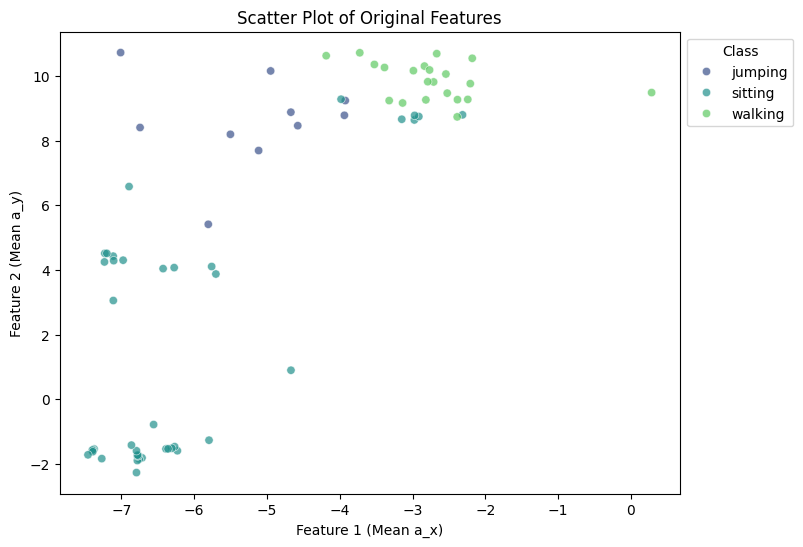

<Figure size 800x600 with 0 Axes>

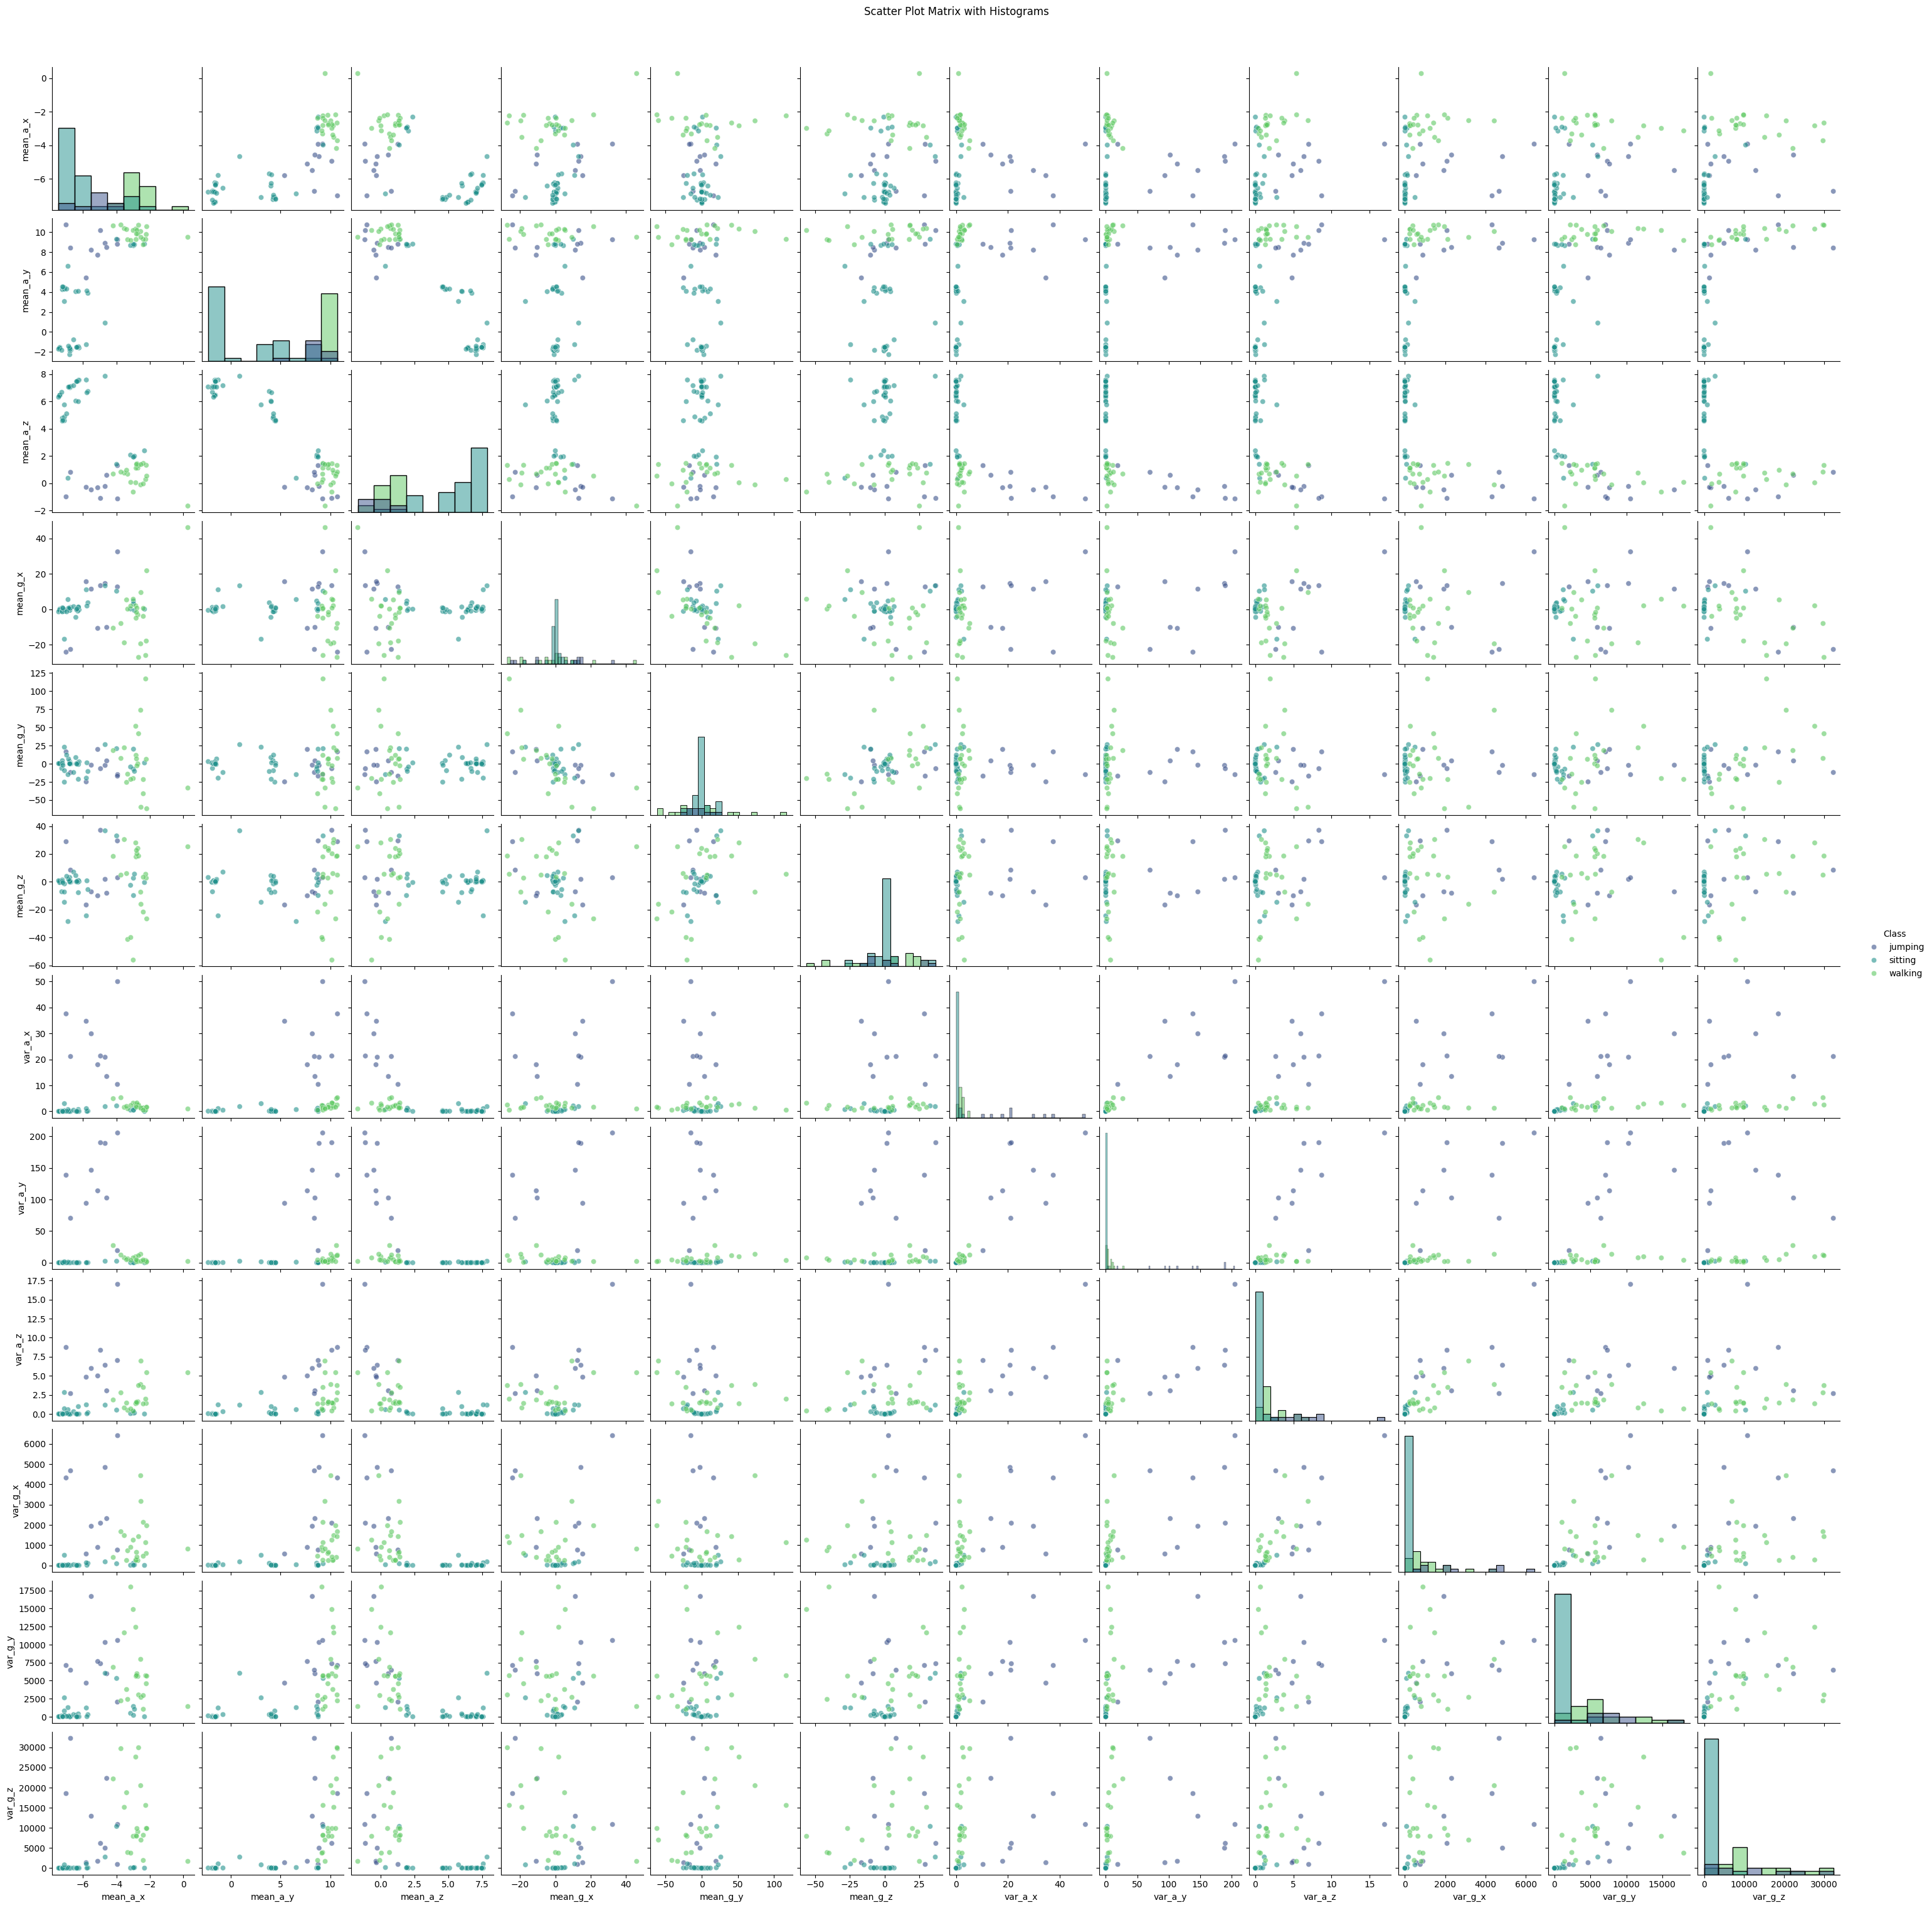

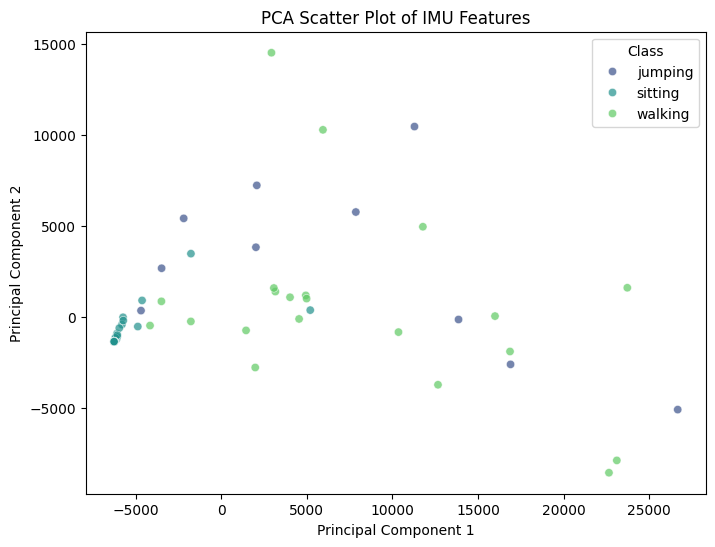

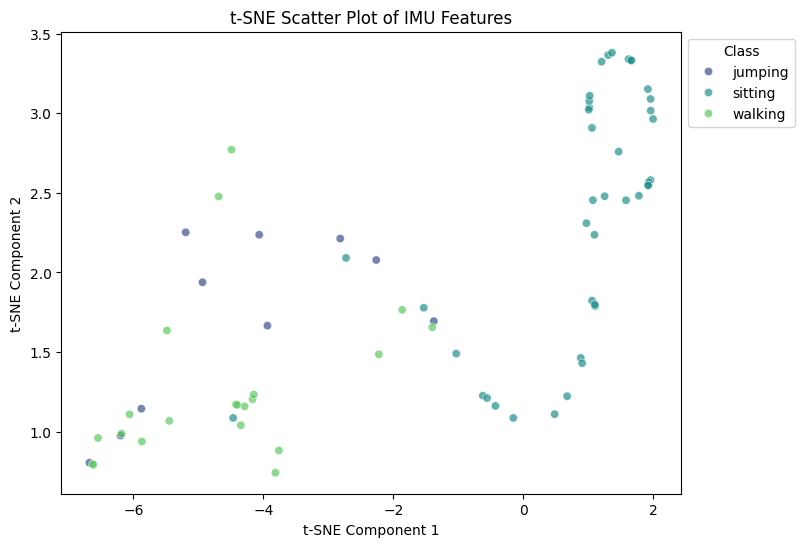

In [2]:
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# === DATA VISUALIZATION ===

# 1. Scatter Plot of Original Features (First Two Features)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette="viridis", alpha=0.7)
plt.xlabel("Feature 1 (Mean a_x)")
plt.ylabel("Feature 2 (Mean a_y)")
plt.title("Scatter Plot of Original Features")
plt.legend(title="Class", bbox_to_anchor=(1, 1))
plt.show()


# 2. Full Scatter Plot
# Convert to DataFrame for easier visualization
feature_names = ["mean_a_x", "mean_a_y", "mean_a_z", "mean_g_x", "mean_g_y", "mean_g_z",
                 "var_a_x", "var_a_y", "var_a_z", "var_g_x", "var_g_y", "var_g_z"]
df_features = pd.DataFrame(X, columns=feature_names)
df_features["Class"] = y  # Add class labels for visualization
plt.figure(figsize=(8, 6))
sns.pairplot(df_features, hue="Class", diag_kind="hist", palette="viridis", plot_kws={'alpha':0.6})
plt.suptitle("Scatter Plot Matrix with Histograms", y=1.02)
plt.show()

# 3. PCA Scatter Plot (First Two Principal Components)
pca = PCA(n_components=2)  # Reduce to 2D for visualization
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="viridis", alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Scatter Plot of IMU Features")
plt.legend(title="Class", bbox_to_anchor=(1, 1))
plt.show()

# 4. t-SNE Scatter Plot
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette="viridis", alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Scatter Plot of IMU Features")
plt.legend(title="Class", bbox_to_anchor=(1, 1))
plt.show()

Accuracy: 1.0
              precision    recall  f1-score   support

     jumping       1.00      1.00      1.00         2
     sitting       1.00      1.00      1.00         9
     walking       1.00      1.00      1.00         4

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



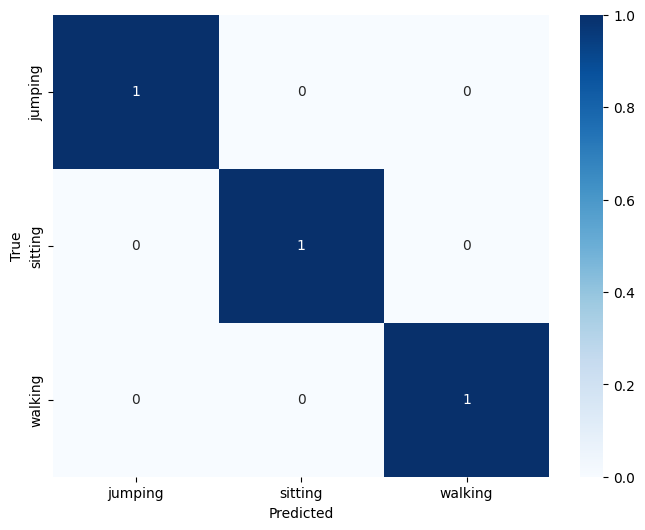

In [3]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# === TRAIN SVM CLASSIFIER ===
svm_model = SVC(kernel="linear", C=0.1, gamma="auto")
svm_model.fit(X_train, y_train)


# === EVALUATE MODEL ===
y_pred = svm_model.predict(X_test)

# === PRINT EVALUATION METRICS ===
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# === PLOT CONFUSION MATRIX ===
# get the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
import time
import threading
import ipywidgets as widgets
import numpy as np
from witmotion import IMU
from sklearn.svm import SVC

SAMPLING_FREQ = 10
SEGMENT_LENGTH = 1
WINDOW_SIZE = SEGMENT_LENGTH * SAMPLING_FREQ

# Feature extraction function: compute mean and variance
def preprocess_data(data):
    """Extract mean and variance features from IMU data."""
    segment = np.array(data)
    # Mean and variance for each axis
    features = segment[:, 1:].mean(axis=0).tolist() + segment[:, 1:].var(axis=0).tolist()
    return np.array(features).reshape(1, -1)

# IMU Recorder class to acquire data
class IMURecorder:
    def __init__(self, port="COM9", filename="imu_data.csv"):
        self.port = port
        self.filename = filename
        self.imu = None
        self.data = []
        self.thread = None
        self.stop_flag = threading.Event()

    def start_acquisition(self):
        """Starts data acquisition in a separate thread."""
        if self.imu is None:
            self.imu = IMU(self.port)  # Open connection

        self.stop_flag.clear()
        self.thread = threading.Thread(target=self._acquire_data, daemon=True)
        self.thread.start()
        print("IMU acquisition started...")

    def _acquire_data(self):
        """Internal method to acquire and save IMU data."""
        start_time = time.time()

        while not self.stop_flag.is_set():
            current_time = time.time() - start_time
            a = self.imu.get_acceleration()
            g = self.imu.get_angular_velocity()

            if a and g:
                self.data.append([current_time, *a, *g])

            time.sleep(1 / SAMPLING_FREQ)  # Sampling interval

    def stop_acquisition(self):
        """Stops the data acquisition and closes the IMU connection."""
        if self.imu:
            self.stop_flag.set()
            self.thread.join()  # Wait for thread to exit
            self.imu.close()  # Properly close IMU connection
            self.imu = None
            print(f"Acquisition stopped.")

    def get_data(self):
        """Returns the recorded IMU data."""
        return np.array(self.data)

# Initialize the IMU recorder
recorder = IMURecorder(port='COM10')

# Start acquisition
recorder.start_acquisition()

# Assuming your model is already loaded, e.g., svm_model = SVC(...)
# Example: svm_model = load_model('your_model_file.pkl') 

# Classify live data every second
class ClassificationThread(threading.Thread):
    def __init__(self, recorder, svm_model):
        super().__init__(daemon=True)
        self.recorder = recorder
        self.svm_model = svm_model
        self.stop_flag = threading.Event()

    def run(self):
        print("Starting live classification...")
        while not self.stop_flag.is_set():
            data = self.recorder.get_data()
            if len(data) >= WINDOW_SIZE:
                features = preprocess_data(data[-WINDOW_SIZE:])
                prediction = self.svm_model.predict(features)
                print(f"Predicted action: {prediction[0]}")
            time.sleep(1)
    
    def stop(self):
        self.stop_flag.set()

classification_thread = ClassificationThread(recorder, svm_model)
classification_thread.start()

# Create a stop button for Jupyter Notebook
stop_button = widgets.Button(description="Stop Acquisition")

def stop_all(b):
    recorder.stop_acquisition()
    classification_thread.stop()
    classification_thread.join()
    print("Classification stopped.")

stop_button.on_click(stop_all)

# Display button in Jupyter
display(stop_button)

IMU acquisition started...
Starting live classification...


Button(description='Stop Acquisition', style=ButtonStyle())

Predicted action: sitting
Predicted action: sitting
Predicted action: sitting
Predicted action: sitting
Predicted action: sitting
Predicted action: sitting
Predicted action: jumping
Predicted action: sitting
Predicted action: sitting
Predicted action: jumping
Predicted action: walking
Predicted action: walking
Predicted action: walking
Predicted action: jumping
Predicted action: jumping
Predicted action: walking
Predicted action: walking
Predicted action: walking
Predicted action: walking
Predicted action: jumping
Predicted action: walking
Predicted action: sitting
Predicted action: sitting
Predicted action: walking
Predicted action: walking
Predicted action: walking
Predicted action: walking
Predicted action: walking
Predicted action: sitting
Predicted action: sitting
Predicted action: sitting
Predicted action: sitting
Predicted action: sitting
Predicted action: sitting
Predicted action: sitting
Predicted action: sitting
Predicted action: sitting
Predicted action: sitting
Predicted ac